In [2]:
npi_model = """
-Develop model to input NPIs, output descriptive statistics
    -% of NPIs with web activity
    -Specialty breakdown
    -Overall usage frequency for those with web activity
    -Session information: multiple websites, or just one?
    -Site category aggregation
    -Disease category aggregation (depending on quality of disease mapping)
"""

for n in npi_model.split('\n'):
    print n


-Develop model to input NPIs, output descriptive statistics
    -% of NPIs with web activity
    -Specialty breakdown
    -Overall usage frequency for those with web activity
    -Session information: multiple websites, or just one?
    -Site category aggregation
    -Disease category aggregation (depending on quality of disease mapping)



In [1]:
%matplotlib inline
from __future__ import division

import pandas as pd
import matplotlib.pyplot as plt
import utils

In [2]:
visitors, events, devices, url_categories = utils.load_data()

/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (5,6,7,8,11,12,13,14,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [4]:
categorized_events = utils.categorize_events(events, url_categories)

match rate: 98.9204202175%


In [6]:
sample_npis = list(visitors[(visitors.professional_designation=='Physician')\
                       &(~visitors.npi_number.isnull())\
                       &(visitors.exclude==0)].npi_number.sample(10000))

In [77]:
v = pd.merge(sample_npis, visitors, on='npi_number')

In [59]:
specialties = v.groupby('primary_specialty').dg_id.count().sort_values(ascending=False).reset_index()

In [63]:
sum(specialties[10:].dg_id)

4278

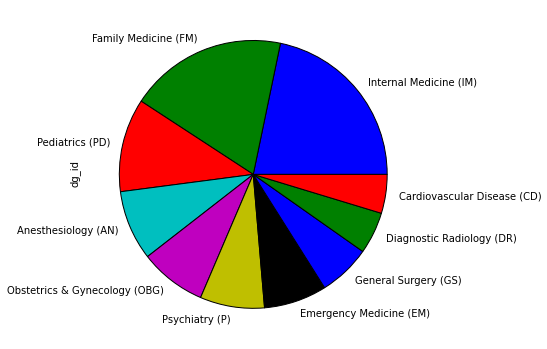

In [64]:
v.groupby('primary_specialty').dg_id.count().sort_values(ascending=False)[:10].plot.pie(figsize=(6,6))

In [78]:
ev = pd.merge(v, events, on='dg_id', how='left')

In [80]:
v.dg_id.nunique()

10000

In [82]:
from __future__ import division

with_web_event = ev[~ev.session_id.isnull()].dg_id.nunique()

ev[~ev.session_id.isnull()].dg_id.nunique()/ev.dg_id.nunique()

0.0613

In [40]:
visitors[visitors.npi_number==1487979332]

,Unnamed: 0,dg_id,identity_type,professional_designation,npi_number,primary_specialty,primary_specialty_group,secondary_specialty,secondary_specialty_group,first_name,last_name,formatted_name,city,state,zipcode,birth_year,grad_year,grad_school,gender,suspected_bot
2415595,2415596,U082400106,AUT,Physician,1.487979e+09,Emergency Medicine (EM),Emergency Medicine,NaN,NaN,ANTHONY,MURINO,ANTHONY D MURINO DO,NEW LENOX,IL,60451-2391,1979,2006,NaN,M,N
2614915,2614916,U085113844,AUT,Physician,1.487979e+09,Unspecified (US),Other,Unspecified (US),Other,ANTHONY,MURINO,ANTHONY D MURINO DO,NEW LENOX,IL,60451-9509,1979,2006,"KS UNIV OF MED & BIOSCI, COLL OF OSTEO MED, KA...",M,N


In [47]:
def categorize_frequency(n):
    if n < 1:
        return 'Less than once a month' 
    elif n <= 10:
        return '1-10 times per month'
    else:
        return 'More than 10x per month'

In [31]:
def summary_statistics(npis):
    v = visitors[visitors.npi_number.isin(npis)]
    ev = pd.merge(v, events, on='dg_id')
    
    # number with web activity
    v['has_event'] = v.dg_id.apply(lambda x: 1 if x in set(ev.dg_id) else 0)
    with_event = v[v.has_event==1].dg_id.nunique()
    total_npis = v.dg_id.nunique()

    print "{} of the {}, or {}%, of NPI numbers submitted have web activity"\
        .format(with_event, total_npis, with_event/total_npis*100)
        
    # frequency of usage
    max_dt = max(events.timestamp).date()
    ev['dt'] = ev.timestamp.apply(lambda x: x.date())
    freq = ev.drop_duplicates(subset=['dg_id', 'dt']).groupby(['dg_id']).dt.agg(['min', 'max', 'count']).reset_index()
    freq['sessions_per_month'] = freq.apply(lambda x: x['count']/(max(1, (max_dt-x['min']).days)/30), axis=1)
    freq['category'] = freq.sessions_per_month.apply(lambda x: categorize_frequency(x))
    freq.groupby('category').dg_id.count().plot.bar()
    
    # specialty breakdown
    vfreq = pd.merge(v, freq[['dg_id', 'sessions_per_month']], on='dg_id')
    vfreq[vfreq.has_event==1].groupby('primary_specialty').dg_id.count().sort_values(ascending=False)[:10].plot.pie(figsize=(6,6))
    
    # frequency by specialty
    
    specialty_frequency = vfreq.groupby('primary_specialty').sessions_per_month.agg(['count', 'mean'])\
                            .loc[lambda x: x['count']>=10].sort_values('mean').reset_index()
    
    print '{} is the least active specialty, with an average of {} sessions per month.'\
        .format(specialty_frequency.primary_specialty[0], round(specialty_frequency['mean'][0],2))
    print '{} is the least active specialty, with an average of {} sessions per month.'\
        .format(specialty_frequency.primary_specialty[len(specialty_frequency)-1], round(specialty_frequency['mean'][len(specialty_frequency)-1],2))
        
    # pages per session
    urls_per_session = ev.groupby(['dg_id', 'session_id']).url.nunique().reset_index().groupby('dg_id').url.mean().reset_index()
    print '{}% of doctors visit more than one page per sessions, with an average of {} pages'\
        .format(round(len(urls_per_session[urls_per_session.url>1])/len(urls_per_session)*100,2), urls_per_session.url.mean())
    
    # url categories
    catev = utils.categorize_events(ev, url_categories)
    site_category_breakdown = \
        catev.groupby(['site_category', 'site_sub_category'])\
        .session_id_x.nunique().reset_index().sort_values('session_id_x', ascending=False)\
        .rename(columns={'session_id_x':'cnt'})
        
    # pharma stuff
    disease_category_breakdown = \
        catev[catev.site_category=='Pharma'].groupby(['primary_specialty','disease_category'])\
        .session_id_x.nunique().reset_index().sort_values('session_id_x', ascending=False)\
        .rename(columns={'session_id_x':'cnt'})

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


630 of the 10000, or 6.3%, of NPI numbers submitted have web activity
Emergency Medicine (EM) is the least active specialty, with an average of 0.52 sessions per month.
Hematology/Oncology (HO) is the least active specialty, with an average of 4.44 sessions per month.
62.7% of doctors visit more than one page per sessions, with an average of 1.64917247456 pages


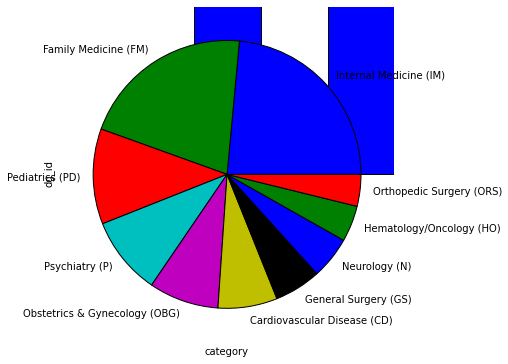

In [119]:
summary_statistics(sample_npis)

In [7]:
v = visitors[visitors.npi_number.isin(sample_npis)]
catev = pd.merge(v, categorized_events, on='dg_id')

In [13]:
len(catev)

8512

In [10]:
catev.columns

Index([u'Unnamed: 0_x', u'dg_id', u'identity_type',
       u'professional_designation', u'npi_number', u'primary_specialty',
       u'primary_specialty_group', u'secondary_specialty',
       u'secondary_specialty_group', u'first_name', u'last_name',
       u'formatted_name', u'city', u'state', u'zipcode', u'birth_year',
       u'grad_year', u'grad_school', u'gender', u'suspected_bot', u'exclude',
       u'Unnamed: 0_y', u'clean_url', u'cnt', u'disease', u'disease_category',
       u'event_clean_url', u'event_url', u'fragment', u'host',
       u'ip_address_fingerprint', u'js_page_cnt', u'machine_fingerprint',
       u'match', u'path', u'pharma_firm', u'query', u'reason', u'referrer',
       u'scheme', u'session_id_x', u'session_id_y', u'site_category',
       u'site_sub_category', u'stripped_url', u'timestamp', u'title', u'url_x',
       u'url_y'],
      dtype='object')

In [28]:
site_category_breakdown = \
    catev.groupby(['site_category', 'site_sub_category'])\
    .session_id_x.nunique().reset_index().sort_values('session_id_x', ascending=False)\
    .rename(columns={'session_id_x':'cnt'})

In [29]:
disease_category_breakdown = \
    catev.groupby(['site_category', 'disease_category'])\
    .session_id_x.nunique().reset_index().sort_values('session_id_x', ascending=False)\
    .rename(columns={'session_id_x':'cnt'})

In [36]:
disease_category_breakdown = \
    catev[catev.site_category=='Pharma'].groupby(['primary_specialty','disease_category'])\
    .session_id_x.nunique().reset_index().sort_values('session_id_x', ascending=False)\
    .rename(columns={'session_id_x':'cnt'})

In [37]:
disease_category_breakdown

,primary_specialty,disease_category,cnt
34,Hematology/Oncology (HO),Obstetrics & Gynecology,16
77,Psychiatry (P),Obstetrics & Gynecology,10
71,Pediatrics (PD),Obstetrics & Gynecology,9
57,Obstetrics & Gynecology (OBG),Obstetrics & Gynecology,8
35,Hematology/Oncology (HO),Oncology,8
19,Family Medicine (FM),Gastroenterology,7
39,Internal Medicine (IM),Endocrinology,6
86,Vascular Surgery (VS),Obstetrics & Gynecology,5
46,Internal Medicine (IM),Oncology,5
48,Internal Medicine (IM),Pediatrics,4


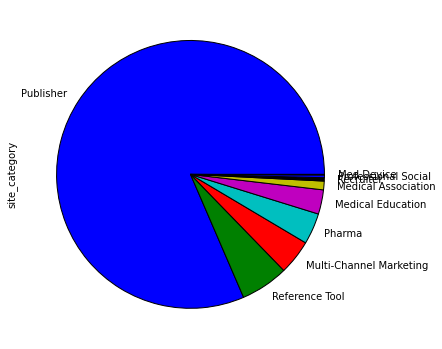

In [184]:
url_events.site_category.value_counts().plot.pie(figsize=(6,6))

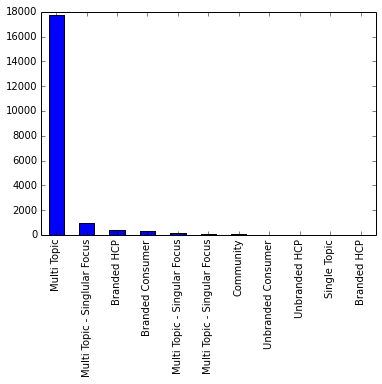

In [191]:
url_events.site_sub_category.value_counts().plot.bar()

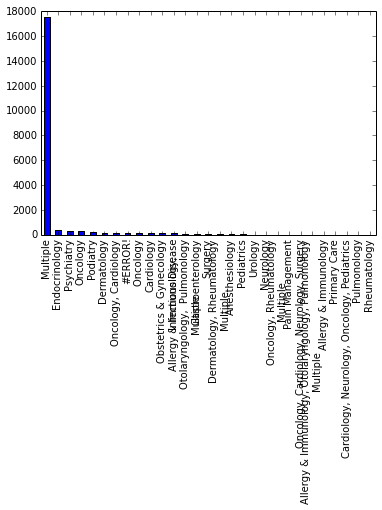

In [192]:
url_events.disease_category.value_counts().plot.bar()

In [185]:
url_categories.groupby(['url_root', 'disease_category')

,url,site_category,site_sub_category,disease_category,disease,url_root
0,http://www.paradigmspine.com/content/are-you-a...,Med Device,Branded Consumer,Surgery,NaN,paradigmspine
1,http://www.paradigmspine.com/content/back-spin...,Med Device,Branded Consumer,Surgery,NaN,paradigmspine
2,http://www.paradigmspine.com/content/coflex-study,Med Device,Branded Consumer,Surgery,NaN,paradigmspine
3,http://www.paradigmspine.com/content/degenerat...,Med Device,Branded Consumer,Surgery,NaN,paradigmspine
4,http://www.paradigmspine.com/content/degenerat...,Med Device,Branded Consumer,Surgery,NaN,paradigmspine
5,http://www.paradigmspine.com/content/glossary,Med Device,Branded Consumer,Surgery,NaN,paradigmspine
6,http://www.paradigmspine.com/content/patients-...,Med Device,Branded Consumer,Surgery,NaN,paradigmspine
7,http://www.paradigmspine.com/content/patient-t...,Med Device,Branded Consumer,Surgery,NaN,paradigmspine
8,http://www.paradigmspine.com/content/spinal-st...,Med Device,Branded Consumer,Surgery,NaN,paradigmspine
9,http://www.paradigmspine.com/content/spondylol...,Med Device,Branded Consumer,Surgery,NaN,paradigmspine


In [193]:
url_categories[url_categories.site_category=='Pharma'].url_root.value_counts()

merckconnect                      11
revlimid                           4
merckvaccines                      4
eliquis                            3
merck                              3
tarceva                            2
herceptin                          2
ocrevus                            2
erivedge                           2
adempas-us                         2
journeyforcontrol                  2
alecensa                           2
lenvima                            2
keytruda                           2
tyvaso                             2
cotellic                           2
cabometyx                          2
astellasclinicalstudyresults       2
gazyva                             2
merckaccessprogram-zepatier        2
kadcyla                            2
merckclarifiesbiosimilars          2
tecentriq                          2
rituxan                            2
perjeta                            2
empliciti                          1
venclexta                          1
a

In [194]:
url_categories[url_categories.url_root=='nuvaring']

,url,site_category,site_sub_category,disease_category,disease,url_root
112,www.nuvaring.com,Pharma,Branded Consumer,#ERROR!,Birth Control,nuvaring


In [ ]:
"once a monther vs frequent users, types of content based on this"
"summary table"